# Mean Variance Frontier with Short Sales Constraints

The code below calculates mean variances frontiers for two cases *(1)* when there are no restrictions on the portfolio weights and *(2)* when we impose the restriction that no weights can be negative.

The latter case requires a numerical minimization routine which comes from the packages [Convex.jl](https://github.com/jump-dev/Convex.jl) (for the interface) and [SCS.jl](https://github.com/jump-dev/SCS.jl) (for the optimization algorithm). To check for convergence, we also need a function from the [MathOptInterface.jl](https://github.com/jump-dev/MathOptInterface.jl) package.

## Load Packages and Utility Functions

In [1]:
using Printf, LinearAlgebra, Convex, SCS
import MathOptInterface
const MOI = MathOptInterface

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))       #use pyplot or gr
gr(size=(480,320))
default(fmt = :svg)

# Traditional MV Calculations 

(no constraints)

In [3]:
μ = [11.5; 9.5; 6]/100      #expected returns
Σ  = [166  34  58;          #covariance matrix
       34  64   4;
       58   4 100]/100^2                  
Rf = 0.03

printblue("μ:")
printmat(μ)
printblue("Σ:")
printmat(Σ)
printblue("Rf:")
printlnPs(Rf)

μ:
     0.115
     0.095
     0.060

Σ:
     0.017     0.003     0.006
     0.003     0.006     0.000
     0.006     0.000     0.010

Rf:
     0.030


## From Chapter on MV Analysis

The file included below contains the functions `MVCalc()`, `MVCalcRf()` and `MVTangencyP()` from the chapter on MV analysis.

In [4]:
include("jlFiles/MvCalculations.jl")

MVTangencyP

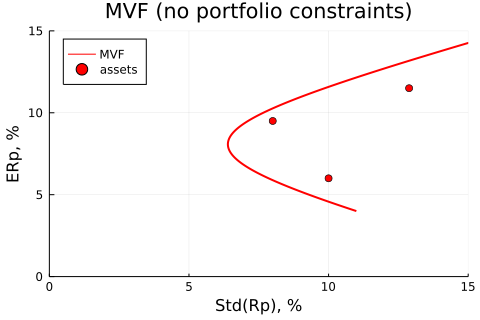

In [5]:
μstar  = range(0.04,stop=0.15,length=201)
L      = length(μstar)
StdRp  = fill(NaN,L)
for i = 1:L
    StdRp[i] = MVCalc(μstar[i],μ,Σ)[1]
end    

p1 = plot( StdRp*100,μstar*100,
           linecolor = :red,
           linewidth = 2,
           label = "MVF",
           legend = :topleft,
           xlim = (0,15),
           ylim = (0,15),
           title = "MVF (no portfolio constraints)",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="assets")
display(p1)

# MV Frontier when Short Sales are Not Allowed

The code below solves the following minimization problem 

$\min \text{Var}(R_p) \: \text{ s.t. } \: \text{E}R_p = \mu^*$,
 
and where we also require $w_i\ge 0$ and $\sum_{i=1}^{n}w_{i}=1$.

In [6]:
"""
    MeanVarNoSSPs(μ,Σ,μstar)

Calculate mean variance frontier when short sales are not allowed, using Convex and SCS


# Input
- `μ::Vector`:        n vector, mean returns
- `Σ::Matrix`:        nxn, covariance matrix of returns, can contain riskfree assets
- `μstar::Vector`:    K vector, mean returns to calculate results for

# Output
- `StdRp::Vector`:    K vector, standard deviation of mean-variance portfolio (risky only) with mean μstar
- `w_p::Matrix`:      Kxn, portfolio weights of       ""

# Requires
- Convex and SCS

"""
function MeanVarNoSSPs(μ,Σ,μstar)   #MV with no short-sales, numerical minimization

    (K,n) = (length(μstar),length(μ))

    n    = length(μ)
    vv   = findall( minimum(μ) .<= μstar .<= maximum(μ) )  #solve only if feasible

    w    = Variable(n)
    Varp = quadform(w,Σ)
    c1   = sum(w) == 1
    c3   = 0 <= w
    c4   = w <= 1

    (w_p,StdRp) = (fill(NaN,K,n),fill(NaN,K))
    for i in vv         #loop over (feasible) μstar elements
        c2      = dot(w,μ) == μstar[i]
        problem = minimize(Varp,c1,c2,c3,c4)
        solve!(problem,()->SCS.Optimizer(verbose=false))
        if problem.status == MOI.OPTIMAL        #check if solution has been found
            w_p[i,:] = evaluate(w)
            StdRp[i] = sqrt(evaluate(Varp))
        end
    end

    return StdRp, w_p

end

MeanVarNoSSPs

In [7]:
MeanVarNoSSPs(μ,Σ,0.10)    #testing the function on a single μstar element

([0.0765998697744827], [0.28815152830346846 0.6900477987824886 0.021800697488835997])

In [8]:
Std_no_ss = MeanVarNoSSPs(μ,Σ,μstar)[1];

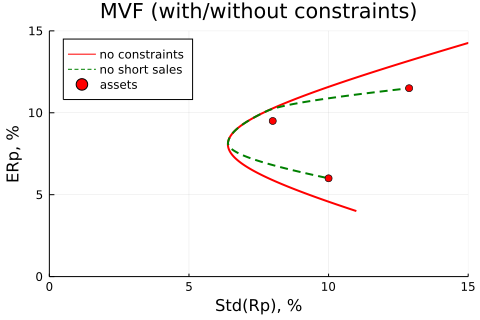

In [9]:
p1 = plot( [StdRp Std_no_ss]*100,μstar*100,
           linecolor = [:red :green],
           linestyle = [:solid :dash],
           linewidth = 2,
           label = ["no constraints" "no short sales"],
           xlim = (0,15),
           ylim = (0,15),
           legend = :topleft,
           title  = "MVF (with/without constraints)",
           xlabel = "Std(Rp), %",
           ylabel = "ERp, %" )
scatter!(sqrt.(diag(Σ))*100,μ*100,color=:red,label="assets")
display(p1)